In [ ]:
# !jupyter nbconvert --to script ./print_model.ipynb

In [2]:
from options.train_options import TrainOptions 
from dataloader import create_dataset
from models import create_model
from utils.visualizer import Visualizer

import wandb
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import imageio
import os

opt = TrainOptions().parse(isCodeCheck=True)
opt.batch_size = 2
torch.cuda.set_device(3)
vis = Visualizer(opt)
dataset = create_dataset(opt)  
dataset_size = len(dataset)    
print('The number of training images = {}'.format(dataset_size))
# model = create_model(opt)     
# model.setup()
# model.train_mode()

----------------- Options ---------------
               batch_size: 8                             
                    beta1: 0.5                           
          checkpoints_dir: ./checkpoints                 
           continue_train: False                         
              crop_size_h: 256                           
              crop_size_w: 256                           
                 dataroot: /all_data/Scannet_ssim        
             dataset_mode: semi_cycle                    
                    debug: False                         
            deterministic: False                         
           disc_for_depth: False                         
         disc_for_normals: False                         
                  dropout: False                         
              epoch_count: 1                             
                 gan_mode: lsgan                         
                  gpu_ids: 1,2                           
              hole_border: -0.

In [3]:
for input in dataset:
    name_A = input['A_name']
    name_B = input['B_name']
    A_K = input['A_K']
    B_K = input['B_K']
    A_crop = input['A_crop']
    B_crop = input['B_crop']
    real_img_A = input['A_img']
    real_depth_A = input['A_depth']
    real_img_B = input['B_img']
    real_depth_B = input['B_depth']
    real_norm_A = input['A_norm']
    real_norm_B = input['B_norm']
    break
    

In [4]:
D = imageio.imread(os.path.join('/all_data/Scannet_all_data/raw/',name_A[0][:-4]+'.png'))
D = dataset.dataset.normalize_depth(D)
d = D[A_crop[0,0]:A_crop[0,1],A_crop[0,2]:A_crop[0,3]].astype(np.float32)
np.linalg.norm((d-real_depth_A[0,0].numpy()).reshape(-1))

0.0

In [5]:
import sys
sys.path.append('../perceptual-depth-sr/src/depth_utils/')
from normals import coords_to_normals
from reprojections import depth_to_absolute_coordinates

In [6]:
K = np.loadtxt(os.path.join('/all_data/Scannet/', name_A[0][:12], 'intrinsic', 'intrinsic_depth.txt'))[:3,:3]
PC = depth_to_absolute_coordinates((D + 1.) / 2.,'orthogonal', K=K)
pc = PC[:,A_crop[0,0]:A_crop[0,1],A_crop[0,2]:A_crop[0,3]]

In [7]:
dd = torch.as_tensor(D[A_crop[0,0]:A_crop[0,1],A_crop[0,2]:A_crop[0,3]])
my_pc = dataset.dataset.depth_to_absolute_coordinates((dd + 1.)/2., 'orthogonal', A_crop[0,0],A_crop[0,1],A_crop[0,2],A_crop[0,3], K, 0.5)

In [8]:
torch.linalg.norm((pc - my_pc).reshape(-1))

tensor(0., dtype=torch.float64)

In [9]:
torch.linalg.norm((coords_to_normals(pc) - real_norm_A[0]).reshape(-1))

tensor(0., dtype=torch.float64)

In [12]:
N = coords_to_normals(PC)
n = N[0,:,A_crop[0,0]:A_crop[0,1],A_crop[0,2]:A_crop[0,3]]

In [15]:
torch.linalg.norm((n[2:-2,2:-2] - real_norm_A[0][2:-2,2:-2]).reshape(-1))

tensor(0., dtype=torch.float64)

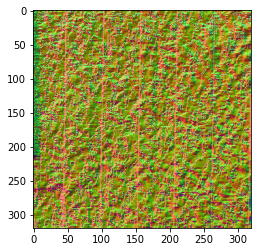

In [16]:
plt.imshow((real_norm_A[0].permute(1,2,0).numpy() + 1.) / 2.)


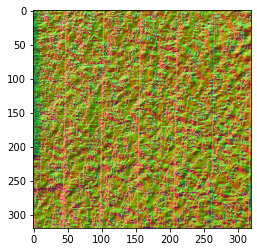

In [17]:
plt.imshow((n.permute(1,2,0).numpy() + 1.) / 2.)

In [7]:
A_crop[0]

tensor([  5, 325, 197, 517])

In [5]:
В = imageio.imread(os.path.join('/all_data/Scannet_ssim/trainA/depth/',name_A[1]+'.png')).astype(np.float64)
K_a0 = np.loadtxt(os.path.join('/all_data/Scannet/', name_A[1][:12], 'intrinsic', 'intrinsic_depth.txt'))[:3,:3]
ha0, ha0_, wa0, wa0_ = crop_indx(name_A[1])

In [6]:
pc_a0 = depth_to_absolute_coordinates(d_a0/5100., 'orthogonal', ha0, ha0_, wa0, wa0_, K=K_a0, shift=0.5)
n_a0 = coords_to_normals(pc_a0)

In [7]:
torch.linalg.norm((real_norm_A[1] - n_a0[0].type(torch.float32)).reshape(-1))

tensor(0.)

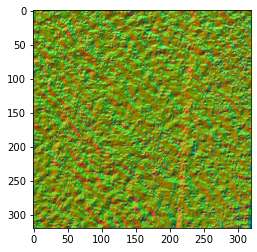

In [8]:
plt.imshow((n_a0[0].permute(1,2,0).numpy() + 1.) / 2.)

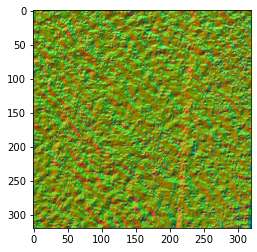

In [9]:
plt.imshow((real_norm_A[1].permute(1,2,0).numpy() + 1.) / 2.)

In [1]:
import torch 
import torch.nn as nn


In [4]:
x = torch.rand([3,3,10,10])
f = nn.Conv2d(3,3,3,1,1)
g = nn.Conv2d(3,3,3,1,1)
criterion = nn.L1Loss()

In [5]:
x_ = f(x)

In [7]:
x__ = f(g(x_))

In [8]:
l = criterion(x_, x__)

In [9]:
l.backward()

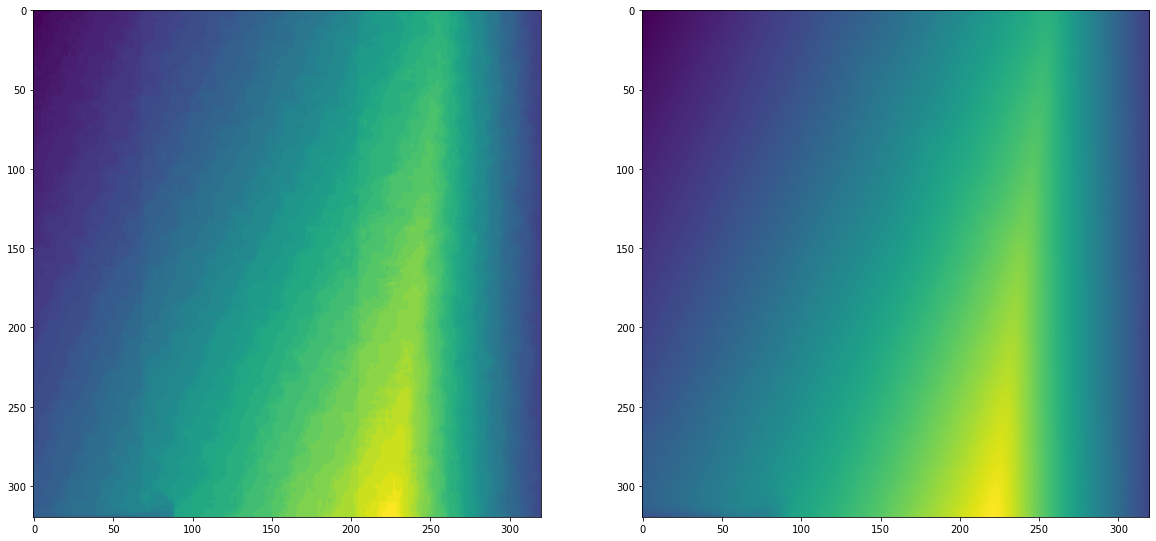

In [30]:
import matplotlib.pyplot as plt
import imageio
import os
raw = os.listdir('/all_data/hdd/un_depth/Scannet_filtered/trainA/depth/')
render = os.listdir('/all_data/hdd/un_depth/Scannet_filtered/trainA/render/')
f, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(imageio.imread(os.path.join('/all_data/hdd/un_depth/Scannet_filtered/trainA/depth/',raw[0])))
ax[1].imshow(imageio.imread(os.path.join('/all_data/hdd/un_depth/Scannet_filtered/trainA/render/',render[0])))

In [28]:
def get_normal(depth):
    norm = np.zeros(( depth.shape[0], depth.shape[1], 3))
    dzdx = np.gradient(depth, 1, axis=0)
    dzdy = np.gradient(depth, 1, axis=1)
    norm[ :, :, 0] = -dzdx
    norm[ :, :, 1] = -dzdy
    norm[ :, :, 2] = np.ones_like(depth)
    n = np.linalg.norm(norm, axis = 2, ord=2, keepdims=True)
    norm = norm/(n + 1e-15)
    return norm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


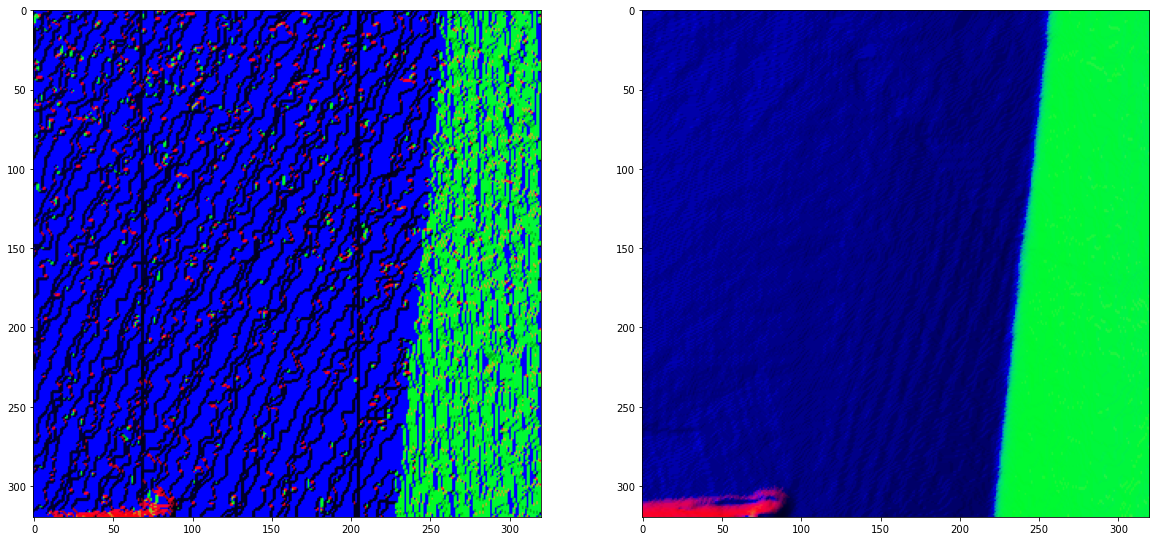

In [31]:
f, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(get_normal(imageio.imread(os.path.join('/all_data/hdd/un_depth/Scannet_filtered/trainA/depth/',raw[0]))))
ax[1].imshow(get_normal(imageio.imread(os.path.join('/all_data/hdd/un_depth/Scannet_filtered/trainA/render/',render[0]))))

In [16]:
up = UnPackBlock(32, 16, 2, 4, False)

In [17]:
out = up(x)

torch.Size([8, 16, 64, 64])


In [14]:
out.shape

torch.Size([8, 16, 128, 128])

In [53]:
import torch
print(torch.__version__)

1.5.1


In [1]:
import os       
os.chdir('/workspace/my_cyclegan')

In [16]:
def f(a1, a2=None, a3=None,a4=None,a5=None):
    print(a1)
    print(a2,'a2')
    print(a3)
    print(a4)
    print(a5)

In [17]:
f(1)

1
None a2
None
None
None


here


In [32]:
import torch
torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True).features

Using cache found in /home/kan/.cache/torch/hub/pytorch_vision_v0.6.0


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [31]:
type(torch.hub.load('pytorch/vision:v0.6.0', 'vgg19', pretrained=True).features[0])

Using cache found in /home/kan/.cache/torch/hub/pytorch_vision_v0.6.0


torch.nn.modules.conv.Conv2d

In [25]:
import numpy as np
a = np.random.rand(5,5,3)
m = np.array([1,2,3], dtype=np.float32)

In [16]:
r = a-m

In [24]:
r.dtype

dtype('float64')

In [19]:
a[:,:,0]

array([[0.21814678, 0.70475286, 0.7759429 , 0.09337409, 0.2701486 ],
       [0.43705938, 0.19839227, 0.1883785 , 0.94352596, 0.19513756],
       [0.11861378, 0.64758191, 0.4987683 , 0.78880975, 0.50023001],
       [0.03210715, 0.92262451, 0.03343856, 0.46924025, 0.01639144],
       [0.95281633, 0.90426156, 0.11956774, 0.49366376, 0.45794611]])

In [20]:
r[:,:,0]

array([[-0.78185322, -0.29524714, -0.2240571 , -0.90662591, -0.7298514 ],
       [-0.56294062, -0.80160773, -0.8116215 , -0.05647404, -0.80486244],
       [-0.88138622, -0.35241809, -0.5012317 , -0.21119025, -0.49976999],
       [-0.96789285, -0.07737549, -0.96656144, -0.53075975, -0.98360856],
       [-0.04718367, -0.09573844, -0.88043226, -0.50633624, -0.54205389]])

In [23]:
0.21814678-1

-0.78185322

In [9]:
featuresort torch
import torch.nn as nn
import imageio
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
class SurfaceNormals(nn.Module):
    def __init__(self):
        super(SurfaceNormals, self).__init__()
#     def forward(self, depth):
#         norm = torch.empty((3,depth.shape[1], depth.shape[2]))
#         norm[0,:,:] = -self.gradient_for_normals(depth, axis=1)
#         norm[1,:,:] = -self.gradient_for_normals(depth, axis=2)
#         norm[2,:,:] = torch.ones((depth.shape[1], depth.shape[2]))
#         n = torch.norm(norm, p=2, dim = 0, keepdim=True)
#         return norm / (n + 1e-5)
    def forward(self, depth):
        dzdx = -self.gradient_for_normals(depth, axis=2)
        dzdy = -self.gradient_for_normals(depth, axis=3)
        norm = torch.cat((dzdx, dzdy, torch.ones_like(depth)), dim=1)
        n = torch.norm(norm, p=2, dim=1, keepdim=True)
        return torch.div(norm, torch.add(n, 1e-6))
    def gradient_for_normals(self, f, axis=None):
        N = f.ndim  # number of dimensions
        dx = 1.0
    
        # use central differences on interior and one-sided differences on the
        # endpoints. This preserves second order-accuracy over the full domain.
        # create slice objects --- initially all are [:, :, ..., :]
        slice1 = [slice(None)]*N
        slice2 = [slice(None)]*N
        slice3 = [slice(None)]*N
        slice4 = [slice(None)]*N
    
        otype = f.dtype
        if otype is torch.float32:
            pass
        else:
            raise TypeError('Input shold be torch.float32')
    
        # result allocation
        out = torch.empty_like(f, dtype=otype)
    
        # Numerical differentiation: 2nd order interior
        slice1[axis] = slice(1, -1)
        slice2[axis] = slice(None, -2)
        slice3[axis] = slice(1, -1)
        slice4[axis] = slice(2, None)
    
        out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * dx)
    
        # Numerical differentiation: 1st order edges
        slice1[axis] = 0
        slice2[axis] = 1
        slice3[axis] = 0
        dx_0 = dx 
        # 1D equivalent -- out[0] = (f[1] - f[0]) / (x[1] - x[0])
        out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0

        slice1[axis] = -1
        slice2[axis] = -1
        slice3[axis] = -2
        dx_n = dx 
        # 1D equivalent -- out[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
        out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
        return out


In [10]:
def normalize_depth(depth):
        if isinstance(depth, np.ndarray):
            if depth.dtype == np.uint16:
                depth = depth.astype(np.float32)
                depth = np.where(depth>8000, 8000, depth)
                depth = depth / 4000 - 1
                return depth
            else:
                print(depth.dtype)
                raise AssertionError('Depth datatype')
        else:
            raise AssertionError('Depth filetype')

In [11]:
def get_normal(depth):
    norm = np.zeros(( depth.shape[0], depth.shape[1], 3))
    dzdx = np.gradient(depth, 1, axis=0)
    dzdy = np.gradient(depth, 1, axis=1)
    norm[ :, :, 0] = -dzdx
    norm[ :, :, 1] = -dzdy
    norm[ :, :, 2] = np.ones_like(depth)
    n = np.linalg.norm(norm, axis = 2, ord=2, keepdims=True)
    norm = norm/(n + 1e-15)
    return norm

In [12]:
norm = SurfaceNormals()
depth = imageio.imread('/all_data/hdd/un_depth/semi/sample/valB/depth/1137_7.png')
# depth = normalize_depth(depth)
depth_z = depth.copy()
depth_noise = depth.copy()
depth_noise[200:300, 250:350] = torch.rand((100, 100))*1000
depth_z[200:300, 250:350] = 0

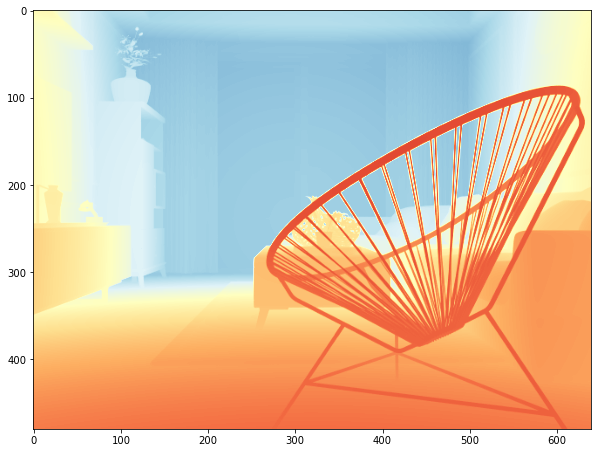

In [13]:
plt.imshow(depth, cmap=plt.get_cmap('RdYlBu'), vmin=0, vmax=8000)

In [ ]:
plt.imshow(depth_z, cmap=plt.get_cmap('RdYlBu'), vmin=0, vmax=8000)

In [ ]:
plt.imshow(depth_noise, cmap=plt.get_cmap('RdYlBu'), vmin=0, vmax=8000)

In [18]:
d = torch.from_numpy(depth.astype(np.float32)).unsqueeze(0).unsqueeze(0)
d.requires_grad=True
d1 = torch.ones_like(d)
# d_z = torch.from_numpy(depth_z.astype(np.float32)).unsqueeze(0)
# d_z.requires_grad=True
# d_noise = torch.from_numpy(depth_noise.astype(np.float32)).unsqueeze(0)
# d_noise.requires_grad=True

In [19]:
n = norm(d)
n1 = norm(d1)

In [20]:
dis = nn.CosineSimilarity(dim=1)

In [24]:
dis(n, n1).shape

torch.Size([1, 480, 640])

In [ ]:
n = norm(d)
n_z = norm(d_z)
n_noise = norm(d_noise)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


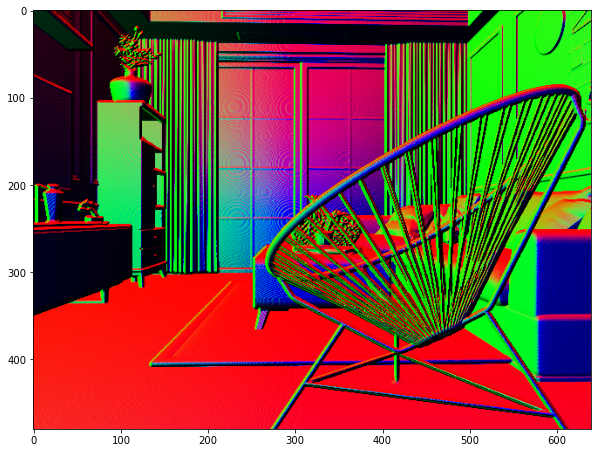

In [22]:
plt.imshow(n[0].permute(1,2,0).data)

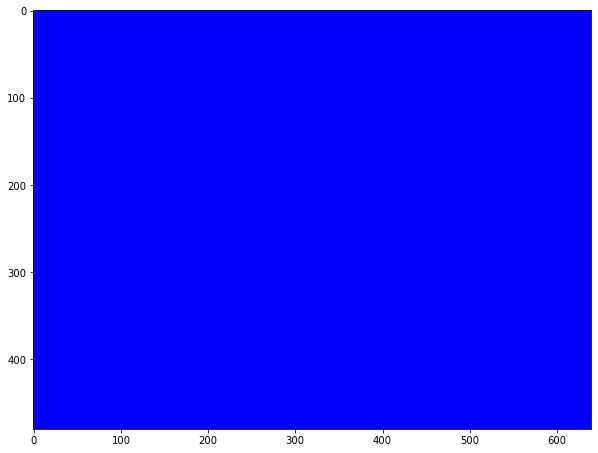

In [23]:
plt.imshow(n1[0].permute(1,2,0).data)

In [ ]:
plt.imshow(n_z.permute(1,2,0).data)

In [ ]:
plt.imshow(n_noise.permute(1,2,0).data)

In [ ]:
grad = torch.rand(3, n.shape[1], n.shape[2])

In [ ]:
n.backward(grad)#
n_z.backward(grad)
n_noise.backward(grad)

In [ ]:
plt.imshow(d.grad[0],cmap=plt.get_cmap('RdYlBu'))

In [ ]:
plt.imshow(d_z.grad[0],cmap=plt.get_cmap('RdYlBu'))

In [ ]:
plt.imshow(d_noise.grad[0],cmap=plt.get_cmap('RdYlBu'))

In [ ]:
plt.imshow(d_noise.grad[0,180:300, 230:350],cmap=plt.get_cmap('RdYlBu'))

In [ ]:
def gradient_for_normals( f, axis=None):
        N = f.ndim  # number of dimensions
        dx = 1.0
    
        # use central differences on interior and one-sided differences on the
        # endpoints. This preserves second order-accuracy over the full domain.
        # create slice objects --- initially all are [:, :, ..., :]
        slice1 = [slice(None)]*N
        slice2 = [slice(None)]*N
        slice3 = [slice(None)]*N
        slice4 = [slice(None)]*N
    
        otype = f.dtype
        if otype is torch.float32:
            pass
        else:
            raise TypeError('Input shold be torch.float32')
    
        # result allocation
        out = torch.empty_like(f, dtype=otype)
    
        # Numerical differentiation: 2nd order interior
        slice1[axis] = slice(1, -1)
        slice2[axis] = slice(None, -2)
        slice3[axis] = slice(1, -1)
        slice4[axis] = slice(2, None)
    
        out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * dx)
    
        # Numerical differentiation: 1st order edges
        slice1[axis] = 0
        slice2[axis] = 1
        slice3[axis] = 0
        dx_0 = dx 
        # 1D equivalent -- out[0] = (f[1] - f[0]) / (x[1] - x[0])
        out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0

        slice1[axis] = -1
        slice2[axis] = -1
        slice3[axis] = -2
        dx_n = dx 
        # 1D equivalent -- out[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])
        out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n
        return out

In [ ]:
xi = i * 1
yi = i * 1
xi.retain_grad()
yi.retain_grad()
dx = gradient_for_normals(xi,1)
dy = gradient_for_normals(yi,2)
dx.retain_grad()
dy.retain_grad()
r = torch.cat((dx,dy,torch.ones_like(dx)), dim=0)
r.retain_grad()
n = torch.norm(r, p=2, dim = 0, keepdim=True)
n.retain_grad()
nn = 1 / n
nn.retain_grad()
r_n = r * nn
r_n.retain_grad()
grad = torch.ones_like(r_n)
r_n.backward(grad)

In [ ]:
torch.allclose(r.sum(dim=0), nn.grad)

In [ ]:
torch.allclose(r.sum(dim=0) * (-1/n**2), n.grad)

In [ ]:
torch.allclose(r.sum(dim=0) * (-1/n**2) * r / n + 1/n, r.grad)

In [ ]:
torch.allclose(xi.grad + yi.grad, i.grad)

In [ ]:
import os
os.chdir('/workspace/my_cyclegan')

from options.train_options import TrainOptions
from dataloader import create_dataset
from models import create_model
from utils.visualizer import Visualizer

import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd

In [ ]:
opt = TrainOptions().parse(isCodeCheck=True)
opt.norm = 'instance'
torch.cuda.set_device(opt.gpu_ids[0])
vis = Visualizer(opt)

In [ ]:
model = create_model(opt)      # create a model given opt.model and other options
model.setup()

In [ ]:
dataset = create_dataset(opt)  
dataset_size = len(dataset)    # get the number of images in the dataset.

In [ ]:
# iteator = iter(dataset)

In [ ]:
# data = next(iteator)
# model.set_input(data)
# model.optimize_param()
# vis.plot_img2depth(model.get_current_vis())

In [ ]:
for data in dataset:
    model.set_input(data)
    model.optimize_param()
    vis.plot_img2depth(model.get_current_vis())
    break

In [ ]:
import numpy as np
a = np.load('/all_data/hdd/un_depth/NYUv2/depth/0_0.npy')
import glob
import imageio

In [ ]:
plt.imshow(a)

In [ ]:
for depth in 

In [ ]:
i = imageio.imread('/all_data/hdd/un_depth/NYUv2/img/0_0.png')

In [ ]:
i

In [ ]:
opt = TrainOptions().parse(isCodeCheck=True)
opt.name = 'pretrain_weights_instance'
opt.load_epoch = 'Nan'
opt.continue_train = True
opt.data_shuffle = True
opt.batch_size = 8
torch.cuda.set_device(opt.gpu_ids[0])

In [ ]:
dataset = create_dataset(opt)  
dataset_size = len(dataset)    # get the number of images in the dataset.
print('The number of training images = %d' % dataset_size)
vis = Visualizer(opt)

In [ ]:
model = create_model(opt)      # create a model given opt.model and other options
model.setup()

In [ ]:
device = torch.device('cuda:0')
criterionL1 = nn.L1Loss()

In [ ]:
syn_rgb = torch.load('./checkpoints/pretrain_weights_instance/img_B.pt').to(device)
syn_depth = torch.load('./checkpoints/pretrain_weights_instance/depth_B.pt').to(device)
norm = model.surf_normals(syn_depth)

In [ ]:
syn_rgb[5] = torch.rand((3,256,256))

In [ ]:
syn_depth[5] = torch.rand((1,256,256))

In [ ]:
fake_depth = model.netG_B(syn_depth, syn_rgb)
fake_norm = model.surf_normals(fake_depth)

In [ ]:
inpt_d = torch.ones((1,1,256,256)) * 1
inpt_d = inpt_d.to(device)
inpt_r = torch.ones((1,3,256,256)) *  0.6549
fake_d = model.netG_B(inpt_d, inpt_r.to(device))
fake_n = model.surf_normals(fake_d)

In [ ]:
loss = criterionL1(inpt_d, fake_d) #+  10 * criterionL1(norm, fake_norm)
loss.backward()

In [ ]:
loss = criterionL1(syn_depth, fake_depth) #+  10 * criterionL1(norm, fake_norm)
loss.backward()

In [ ]:
layer = []
for n, p in model.netG_B.module.named_parameters():
    layer.append(n)

In [ ]:
param_stat = pd.DataFrame(index=layer, columns=['mean_w', 'max_w', 'min_w', 'mean_g', 'max_g', 'min_g'])

In [ ]:
for n, p in model.netG_B.module.named_parameters():
    param_stat['mean_w'][n] = p.mean().item()
    param_stat['max_w'][n] = p.max().item()
    param_stat['min_w'][n] = p.min().item()
    
    param_stat['mean_g'][n] = p.grad.mean().item()
    param_stat['max_g'][n] = p.grad.max().item()
    param_stat['min_g'][n] = p.grad.min().item()

In [ ]:
model.netG_B.module

In [ ]:
param_stat[:21]

In [ ]:
def rec(a, i):
    i += 1
    if a < 3:
        a=rec(a+1, i)
    print(a, i)
    return(a)

In [ ]:
rec(1, 0)

In [ ]:
plt.imshow(syn_depth[5,0].cpu().data,cmap=plt.get_cmap('RdYlBu'))

In [ ]:
torch.unique(syn_depth[5,0])

In [ ]:
plt.imshow(syn_rgb[5,0].cpu())

In [ ]:
torch.unique(syn_rgb[5,0])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        model = [
            nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1, dilation=1, padding_mode='replicate', bias=False),
            nn.InstanceNorm2d(3, affine=True),
            nn.ReLU(True),
            nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1, dilation=1, padding_mode='replicate', bias=True),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

In [ ]:
net  = Net()
criterionL1 = nn.L1Loss()

In [ ]:
from torch.nn import init
init_type='xavier'
init_gain='relu'
param=0.2
def init_func(m):  # define the initialization function
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        if init_type == 'normal':
            init.normal_(m.weight.data, mean=0.0, std=0.02)
        elif init_type == 'xavier':
            init.xavier_normal_(m.weight.data, gain=init.calculate_gain(init_gain, param))#
        elif init_type == 'kaiming':
            init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        elif init_type == 'orthogonal':
            init.orthogonal_(m.weight.data, gain=init.calculate_gain(init_gain, param))
        else:
            raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        if hasattr(m, 'bias') and m.bias is not None:
            init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, mean=1.0, std=0.02)
        init.constant_(m.bias.data, 0.0)
    print('initialize network with %s' % init_type)
net.apply(init_func)  # apply the initialization function <init_func>

In [ ]:
i1 = torch.ones((1,1,3,3))
i2 = torch.rand((1,1,3,3))
# input = torch.cat((i1,i2), dim=0)
input = i1

In [ ]:
out = net(input)

In [ ]:
out

In [ ]:
loss = criterionL1(out, input)

In [ ]:
loss.backward()

In [ ]:
net.model[1].weight

In [ ]:
i1 = torch.ones((1,2,3,3), dtype=torch.float32, requires_grad=True)
i2 = torch.rand((1,2,3,3), dtype=torch.float32, requires_grad=True)
x = torch.cat((i1,i2), dim=0)
x.retain_grad()
gamma = torch.ones((2), dtype=torch.float32, requires_grad=True)
beta = torch.zeros((2), dtype=torch.float32, requires_grad=True)
gamma = gamma.unsqueeze(0).unsqueeze(2).unsqueeze(3)
beta = beta.unsqueeze(0).unsqueeze(2).unsqueeze(3)

In [ ]:
x

In [ ]:
mean = torch.mean(x, dim=(2,3), keepdim=True)
mean.retain_grad()

In [ ]:
mean.shape

In [ ]:
sub = x - mean
sub.retain_grad()

sub1 = sub*1
sub1.retain_grad()
sub2 = sub*1
sub2.retain_grad()

In [ ]:
powsub = torch.pow(sub2,2)
powsub.retain_grad()

In [ ]:
var = torch.mean(powsub, dim=(2,3), keepdim=True)
var.retain_grad()

In [ ]:
std = torch.sqrt(var + 1e-05)
std.retain_grad()

In [ ]:
std1 = 1 / std
std1.retain_grad()

In [ ]:
x_h = sub1 * std1
x_h.retain_grad()

In [ ]:
out = x_h * gamma + beta

In [ ]:
out

In [ ]:
grad =torch.rand((2,2,3,3))
out.backward(grad)

In [ ]:
torch.allclose(x_h.grad, grad * gamma)

In [ ]:
torch.allclose(sub1.grad, gamma*grad*std1)

In [ ]:
torch.allclose(std1.grad, torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True))

In [ ]:
torch.allclose(std.grad, -1/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True))

In [ ]:
torch.allclose(var.grad, -1/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05)))

In [ ]:
torch.allclose(powsub.grad, 1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05)))

In [ ]:
torch.allclose(sub2.grad, 2*sub2*1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05)))

In [ ]:
torch.allclose(sub.grad,gamma*grad*std1 + 2*sub2*1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05)))

In [ ]:
grad_sub = gamma*grad*std1 + 2*sub2*1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05))

In [ ]:
 gamma*grad*std1

In [ ]:
2*sub2*1/(3*3)*(-1)/(var + 1e-05)*torch.sum(gamma*grad*sub1, dim=(2,3), keepdim=True)*0.5*1/(torch.sqrt(var + 1e-05))

In [ ]:
torch.allclose(mean.grad, -1* torch.sum(grad_sub, dim=(2,3), keepdim=True))

In [ ]:
torch.allclose(x.grad,grad_sub -1* torch.sum(grad_sub, dim=(2,3), keepdim=True)* 1/(3*3))

In [ ]:
x.grad

In [ ]:
model.get_current_losses()

In [ ]:
model.netD_A_depth.module

In [ ]:
for n, p in model.netD_A_depth.module.named_parameters():
    if torch.isnan(p).any():
        raise RuntimeError('Nan')

In [ ]:
for name, param in model.netD_A_depth.module.named_parameters():
    print(name, torch.isnan(param.grad).any())

In [ ]:
data['A_semantic'].dtype

In [ ]:
a = torch.tensor([True, False])

In [ ]:
torch.sum(a)

In [ ]:
import imageio
import matplotlib.pyplot as plt

In [ ]:
a = imageio.imread('/all_data/hdd/un_depth/semi/sample/testA/depth/scene0092_01_200.png')
plt.imshow(a)

In [ ]:
import os
os.chdir('/workspace/my_cyclegan')

In [ ]:
# !python train.py --dataroot /all_data/hdd/un_depth/semi/sample\
# --gpu_ids 1\
# --name test\
# --gan_mode vanilla\
# --use_blur\
# --netG resnet_6blocks\
# --ngf_depth 20\
# --ngf_rgb 32\
# --ngf_depth_edge 16\
# --ndf 64\
# --netD n_layers\
# --n_layers_D 3\
# --l_depth_large_A 70\
# --l_depth_small_A 70\
# --l_depth_large_B 10\
# --l_depth_small_B 10\
# --l_depth_max_iter 30000\
# --lambda_cycle_A 5.0\
# --lambda_identity 2.5\
# --lambda_reconstruction 0.0\
# --max_dataset_size 18\
# --batch_size 6\
# --load_size_h 480\
# --load_size_w 640\
# --lr_D 0.0003\
# --lr_G 0.0002\
# --num_iter_gen 3\
# --norm instance\
# --init_type xavier\
# --beta1 0.5\
# --img_freq 1\
# --loss_freq 1\
# --save_epoch_freq 10\
# --n_epochs 10\
# --n_epochs_decay 5\
# # --netG_d2e unet_256\
# # --net_d2e_weights './checkpoints/depth_edge_unet_1.5_weight_binatyloss/last_netG_B.pth'\